In [15]:
import gc
import os
import numpy as np 
import pandas as pd 
import utils.paths as plh
import utils.read_utils as hlpread
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding
from src.models.feature_eng.TFIDFVectorizerEncoding import TFIDFVectorizerEncoding

# Pipeline #

In [16]:
PROJECT_ROOT = plh.get_project_root()

train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
train = hlpread.read_from_parquet(train_data)

print(train.shape)

print(train.columns)
#col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
#train = train[col_use]
#targetcol = 'ACTION'

#te_col = list(train.columns)
#te_col.remove(targetcol)

(30391, 10)
Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')


In [17]:
from sklearn.pipeline import Pipeline

feature_engg = Pipeline( steps = [
                                ('combine_feature', CombineFeatures()),
                                ('tfidf_vectorizer_encoding', TFIDFVectorizerEncoding()),
                                ('KFoldTE', KFoldTargetEncoder()),
                                ])

X = feature_engg.fit_transform(train) 


In [19]:
X.shape

(30391, 90)

In [21]:
X.columns

Index(['ACTION', 'RESOURCE', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE',
       'RESOURCE_ROLE_ROLLUP_1', 'RESOURCE_ROLE_ROLLUP_2',
       'RESOURCE_ROLE_DEPTNAME', 'RESOURCE_ROLE_FAMILY_DESC',
       'RESOURCE_ROLE_FAMILY', 'RESOURCE_ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE', 'RESOURCE_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_FAMILY_svd_cv',
       'RESOURCE_ROLE_ROLLUP_1_ROLE_FAMILY_svd_cv',
       'ROLE_ROLLUP_1_ROLE_FAMILY_svd_cv', 'ROLE_ROLLUP_2_ROLE

In [23]:
X.columns[29:]

Index(['RESOURCE_ROLE_ROLLUP_1_svd_cv', 'RESOURCE_ROLE_FAMILY_svd_cv',
       'RESOURCE_ROLE_ROLLUP_1_ROLE_FAMILY_svd_cv',
       'ROLE_ROLLUP_1_ROLE_FAMILY_svd_cv', 'ROLE_ROLLUP_2_ROLE_FAMILY_svd_cv',
       'ROLE_DEPTNAME_ROLE_ROLLUP_1_svd_cv',
       'ROLE_FAMILY_DESC_ROLE_ROLLUP_1_svd_cv',
       'ROLE_FAMILY_ROLE_ROLLUP_1_svd_cv', 'ROLE_CODE_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_ROLLUP_1_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_ROLLUP_2_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_ROLLUP_2_ROLE_FAMILY_svd_cv',
       'RESOURCE_ROLE_DEPTNAME_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY_svd_cv',
       'RESOURCE_ROLE_FAMILY_DESC_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY_svd_cv',
       'RESOURCE_ROLE_FAMILY_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_FAMILY_ROLE_FAMILY_svd_cv',
       'RESOURCE_ROLE_CODE_ROLE_ROLLUP_1_svd_cv',
       'RESOURCE_ROLE_CODE_ROLE_FAMILY_svd_cv',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_sv

In [3]:
from sklearn.pipeline import Pipeline

#Order of the pipeline matter as this impact the output
feature_engg = Pipeline( steps = [
                                ('combine_feature', CombineFeatures()),

                                ('KFoldTE', KFoldTargetEncoder()),

                                ('frequency_encoding', FrequencyEncoding(min_group_size = 2)),

                                #('tfidf_vectorizer_encoding', TFIDFVectorizerEncoding()),

                                ('count_vectorizer_encoding', CountVectorizerEncoding()),
                                ]
                              ,verbose =  True
                        ) 

X = feature_engg.fit_transform(train) 

[Pipeline] ... (step 1 of 4) Processing combine_feature, total=   0.3s
[Pipeline] ........... (step 2 of 4) Processing KFoldTE, total=  25.5s
[Pipeline]  (step 3 of 4) Processing frequency_encoding, total=   0.4s


f:\github_workspace\employee_access_resource_classifier\env\lib\site-packages\pandas\core\frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


[Pipeline]  (step 4 of 4) Processing count_vectorizer_encoding, total= 2.4min


In [5]:
X.shape

(30391, 249)

In [6]:
X.isna().sum()

ACTION                                                         0
RESOURCE                                                       0
ROLE_ROLLUP_1                                                  0
ROLE_ROLLUP_2                                                  0
ROLE_DEPTNAME                                                  0
                                                              ..
ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv            0
ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_FAMILY_DESC_svd_cv         0
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_ROLLUP_2_svd_cv       0
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_DEPTNAME_svd_cv       0
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_FAMILY_DESC_svd_cv    0
Length: 249, dtype: int64

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

In [8]:
X.columns[30:]

Index(['ROLE_ROLLUP_1_Kfold_TE', 'ROLE_ROLLUP_2_Kfold_TE',
       'ROLE_DEPTNAME_Kfold_TE', 'ROLE_FAMILY_DESC_Kfold_TE',
       'ROLE_FAMILY_Kfold_TE', 'ROLE_CODE_Kfold_TE',
       'RESOURCE_ROLE_ROLLUP_1_Kfold_TE', 'RESOURCE_ROLE_ROLLUP_2_Kfold_TE',
       'RESOURCE_ROLE_DEPTNAME_Kfold_TE', 'RESOURCE_ROLE_FAMILY_DESC_Kfold_TE',
       ...
       'ROLE_FAMILY_DESC_ROLE_CODE_ROLE_ROLLUP_1_ROLE_FAMILY_svd_cv',
       'ROLE_FAMILY_DESC_ROLE_CODE_ROLE_ROLLUP_2_ROLE_FAMILY_svd_cv',
       'ROLE_FAMILY_DESC_ROLE_CODE_ROLE_DEPTNAME_ROLE_FAMILY_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_ROLE_FAMILY_DESC_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_FAMILY_DESC_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_ROLLUP_2_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_DEPTNAME_svd_cv',
       'ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_FAMILY_DESC_svd_cv'],
      d

In [9]:
X[X.columns[30:]].isna().sum()

ROLE_ROLLUP_1_Kfold_TE                                         0
ROLE_ROLLUP_2_Kfold_TE                                         0
ROLE_DEPTNAME_Kfold_TE                                         0
ROLE_FAMILY_DESC_Kfold_TE                                      0
ROLE_FAMILY_Kfold_TE                                           0
                                                              ..
ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv            0
ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_FAMILY_DESC_svd_cv         0
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_ROLLUP_2_svd_cv       0
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_DEPTNAME_svd_cv       0
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_FAMILY_DESC_svd_cv    0
Length: 219, dtype: int64

In [10]:
logreg = LogisticRegressionCV()
logreg.fit(X[X.columns[30:]], train['ACTION'])

f:\github_workspace\employee_access_resource_classifier\env\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
f:\github_workspace\employee_access_resource_classifier\env\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

LogisticRegressionCV()

In [12]:
y_pred = logreg.predict(X[X.columns[30:]])

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(train['ACTION'], y_pred)
print(confusion_matrix)

[[    2  1838]
 [   12 28539]]


In [14]:
from sklearn.metrics import classification_report
print(classification_report(train['ACTION'], y_pred))

              precision    recall  f1-score   support

           0       0.14      0.00      0.00      1840
           1       0.94      1.00      0.97     28551

    accuracy                           0.94     30391
   macro avg       0.54      0.50      0.49     30391
weighted avg       0.89      0.94      0.91     30391



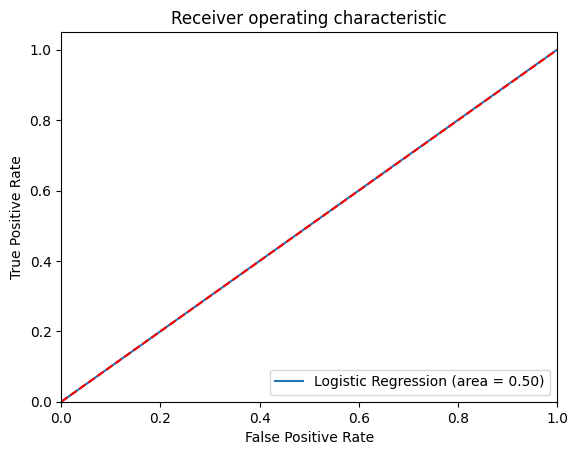

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
logit_roc_auc = roc_auc_score(train['ACTION'], y_pred)
fpr, tpr, thresholds = roc_curve(train['ACTION'], y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Temp #

In [23]:
from sklearn.pipeline import Pipeline

#Order of the pipeline matter as this impact the output
feature_engg = Pipeline( steps = [
                                ('combine_feature', CombineFeatures()),

                                ('KFoldTE', KFoldTargetEncoder()),

                                ('frequency_encoding', FrequencyEncoding(min_group_size = 2))])
X = feature_engg.fit_transform(train)

In [24]:
X.shape

(30391, 87)

In [40]:
X.reset_index(drop = True, inplace = True)

In [41]:
cnt_vector = hlpread.read_from_parquet( os.path.join(PROJECT_ROOT, 
                hlpread.read_yaml_key('data_source.data_folders'),
                hlpread.read_yaml_key('featurize.count_vector.output.folder'),
                hlpread.read_yaml_key('featurize.count_vector.output.filename'),
))
cnt_vector.reset_index(drop = True, inplace = True)
cnt_vector.shape

(30391, 164)

In [42]:
cnt_vector.ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv

0        2603.088153
1          81.123265
2           0.908876
3        3692.989815
4           0.028088
            ...     
30386    3692.989815
30387       0.914198
30388       3.002527
30389      22.738838
30390       0.794272
Name: ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv, Length: 30391, dtype: float64

In [43]:
X.RESOURCE

0        39353
1        17183
2        36724
3        36135
4        42680
         ...  
30386    23497
30387    25139
30388    34924
30389    80574
30390    14354
Name: RESOURCE, Length: 30391, dtype: object

In [44]:
Y = pd.merge(X, cnt_vector, left_index = True, right_index = True, how = 'inner')
Y.shape

(30391, 251)

In [32]:
Y.isna().sum()

ACTION                                                            0
RESOURCE                                                          0
MGR_ID                                                            0
ROLE_ROLLUP_1                                                     0
ROLE_ROLLUP_2                                                     0
                                                               ... 
ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv            2099
ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_FAMILY_DESC_svd_cv         2099
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_ROLLUP_2_svd_cv       2099
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_DEPTNAME_svd_cv       2099
ROLE_FAMILY_ROLE_CODE_ROLE_ROLLUP_1_ROLE_FAMILY_DESC_svd_cv    2099
Length: 251, dtype: int64

In [34]:
Y.ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv

0        2603.088153
1          81.123265
2           0.908876
3        3692.989815
4           0.028088
            ...     
32764            NaN
32765            NaN
32766            NaN
32767            NaN
32768            NaN
Name: ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv, Length: 30391, dtype: float64

In [33]:
Y[Y.isna()].ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
32764   NaN
32765   NaN
32766   NaN
32767   NaN
32768   NaN
Name: ROLE_FAMILY_ROLE_CODE_RESOURCE_ROLE_ROLLUP_1_svd_cv, Length: 30391, dtype: float64

In [ ]:
tfidf_vector  = hlpread.read_from_parquet( os.path.join(PROJECT_ROOT, 
                hlpread.read_yaml_key('data_source.data_folders'),
                hlpread.read_yaml_key('featurize.tfidf.output.folder'),
                hlpread.read_yaml_key('featurize.tfidf.output.filename'),
))

tfidf_vector.shape

In [ ]:
X = pd.merge(freq_encoder_X, kte_encoder_X, left_index = True, right_index = True, how = 'inner')
X = pd.merge(tfidf_vector, X, left_index = True, right_index = True, how = 'left')
print(X.shape)

In [ ]:
Y = train['ACTION']

X = pd.merge(freq_encoder_X, tfidf_vector, left_index = True, right_index = True, how = 'inner')
#X = pd.merge(kte_encoder_X, X, left_index = True, right_index = True, how = 'inner')
print(X.shape)
X.isna().sum()

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv = LogisticRegressionCV(Cs=7,                            
                            max_iter = 100,
                            class_weight = 'balance',
                            cv = 5)

lr_cv.fit(X, Y)